In [1]:
import os
import zipfile
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from kaggle_datasets import KaggleDatasets
from numpy import save
from numpy import asarray
from os import listdir
import matplotlib as mpl
from numpy import load
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator





In [2]:
train_df=pd.read_csv('/kaggle/input/aptos-prepare-train-and-validation-set/train.csv')
validation_df=pd.read_csv('/kaggle/input/aptos-prepare-train-and-validation-set/validation.csv')

In [3]:
train_df.head()

,id_code,diagnosis
0,f2d2a0c92034.png,4
1,e933923aab15.png,0
2,7bda86d95c5b.png,2
3,b7983cb3f270.png,0
4,a77dbec966d4.png,1


In [4]:
fmap1=train_df['diagnosis'].value_counts()
print(fmap1)

4    1718
3    1718
2    1718
1    1718
0    1718
Name: diagnosis, dtype: int64


In [5]:
validation_df.head()

,id_code,diagnosis
0,2bbcfdc477db.png,4
1,7a46cfa69bae.png,0
2,64ac539f58cb.png,0
3,e9ce5bf645ab.png,0
4,7d261f986bef.png,2


In [6]:
fmap2=validation_df['diagnosis'].value_counts()
print(fmap2)

0    87
2    45
1    25
4    15
3    12
Name: diagnosis, dtype: int64


In [7]:
path_for_gcs=KaggleDatasets().get_gcs_path('aptos2019-blindness-detection')
print(path_for_gcs)

gs://kds-f13392a9101086a9c343c73cb5ea6bb41cdd880fa1f96874ffdce072


In [8]:
train_files_path=[path_for_gcs+'/train_images/'+ fname for fname in train_df['id_code']]
validation_files_path=[path_for_gcs+'/train_images/'+ fname for fname in validation_df['id_code']]
train_labels=list(train_df['diagnosis'])
validation_labels=list(validation_df['diagnosis'])

In [9]:


print(train_files_path[0])
print(validation_files_path[0])



gs://kds-f13392a9101086a9c343c73cb5ea6bb41cdd880fa1f96874ffdce072/train_images/f2d2a0c92034.png
gs://kds-f13392a9101086a9c343c73cb5ea6bb41cdd880fa1f96874ffdce072/train_images/2bbcfdc477db.png


In [10]:
#TPU setup
try:
    tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU")
except ValueError:
    tpu=None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy=tf.distribute.experimental.TPUStrategy(tpu)
else:
    tpu_strategy=tf.distribute.get_strategy()
print("REPLICAS ",tpu_strategy.num_replicas_in_sync)

Running on TPU
REPLICAS  8


In [11]:


#predefined variable
IMG_WIDTH=512
IMG_HEIGHT=512
BATCH_SIZE=16*tpu_strategy.num_replicas_in_sync#take thumb rule
AUTOTUNE = tf.data.experimental.AUTOTUNE 
EPOCHS = 10
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE
print(STEPS_PER_EPOCH)



67


In [12]:


def parse_function_for_train(filename,label):
    image_string=tf.io.read_file(filename)
    image_decoded=tf.image.decode_png(image_string,channels=3)
    image_decoded=image_aug(image_decoded)
    image_resized=tf.image.resize(image_decoded,[IMG_WIDTH,IMG_HEIGHT])
    image_normalized=image_resized/255.0
    label=tf.dtypes.cast(label,tf.int32)
    label=tf.one_hot(label,5)
    return image_normalized,label



In [13]:


def parse_function_for_validate(filename,label):
    image_string=tf.io.read_file(filename)
    image_decoded=tf.image.decode_png(image_string,channels=3)
    image_resized=tf.image.resize(image_decoded,[IMG_WIDTH,IMG_HEIGHT])
    image_normalized=image_resized/255.0
    label=tf.dtypes.cast(label,tf.int32)
    label=tf.one_hot(label,5)
    return image_normalized,label



In [14]:


def image_aug(img):
    img=tf.image.adjust_gamma(img,gamma=1, gain=1)
    img=tf.image.adjust_contrast(img,1)
    #img = tf.image.random_flip_left_right(img) horizontal flip
    img=X = tf.image.random_flip_up_down(img) #vertical flip
    img = tf.image.random_brightness(img, max_delta = 0.1)
    img = tf.image.random_saturation(img, lower = 0.75, upper = 1.5)
    img = tf.image.random_hue(img, max_delta = 0.15)
    img = tf.image.random_contrast(img, lower = 0.75, upper = 1.5)
    return img



In [15]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    if is_training:
        dataset = dataset.map(parse_function_for_train, num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(parse_function_for_validate, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [16]:
train_dataset=create_dataset(train_files_path,train_labels)

In [17]:
validation_dataset=create_dataset(validation_files_path,validation_labels,is_training=False)

In [18]:


def print_image_from_dataset(dataset,number):
    images_ds=dataset.map(lambda image,label :image).unbatch()
    labels_ds=dataset.map(lambda image,label :label).unbatch()
    images=next(iter(images_ds.batch(validation_df.shape[0]))).numpy()
    labels=next(iter(labels_ds.batch(validation_df.shape[0]))).numpy()
    for i in range(number):
        print(images[i].shape)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.show()



(512, 512, 3)


/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


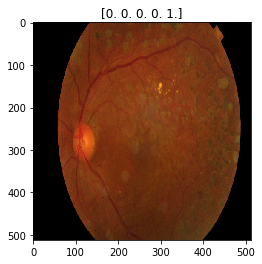

(512, 512, 3)


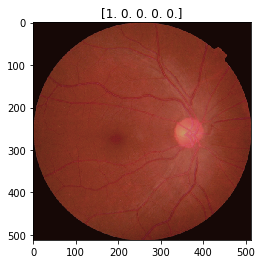

(512, 512, 3)


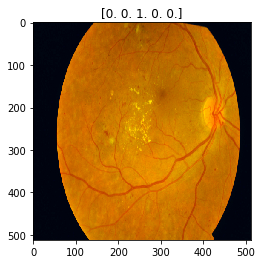

(512, 512, 3)


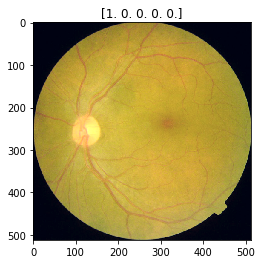

(512, 512, 3)


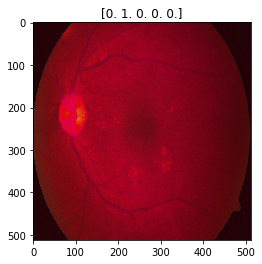

(512, 512, 3)


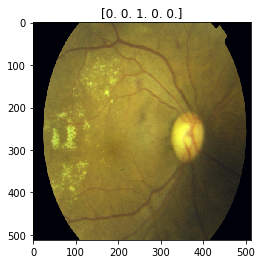

(512, 512, 3)


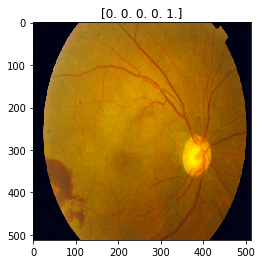

(512, 512, 3)


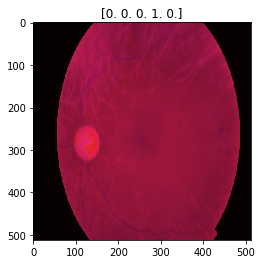

(512, 512, 3)


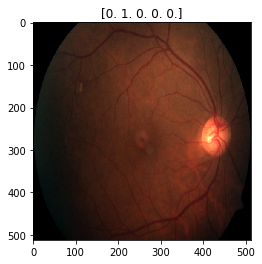

(512, 512, 3)


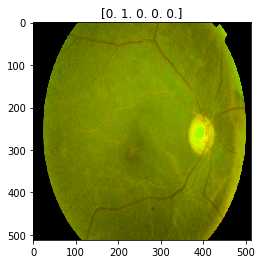

In [19]:
print_image_from_dataset(train_dataset,10) #we are checking if the augmentation worked properly

In [20]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [21]:
metrices=[tf.keras.metrics.CategoricalAccuracy(name='acc')]

In [22]:
with tpu_strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        weights='imagenet',#'imagenet if training for first time'
        include_top=False
    )
    enet.trainable = True
    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=metrices
    )
    model.summary()

258441216/258434480 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 12805     
Total params: 64,110,485
Trainable params: 63,799,765
Non-trainable params: 310,720
_________________________________________________________________


In [23]:
model.load_weights('/kaggle/input/aptos-blindness-detection-augmentation/efficientnetb7epochs36weightswithoversamplingnoimgaugpart0.hdf5')

In [24]:
histories=[]
for i in range(EPOCHS):
    print("EPOCHS",i+1)
    history = model.fit(
        train_dataset, 
        epochs=1,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=validation_dataset,validation_steps=2
    )
    histories.append(history)

EPOCHS 1
Train for 67 steps, validate for 2 steps
67/67 [==============================] - 1046s 16s/step - loss: 0.6259 - acc: 0.7836 - val_loss: 0.9491 - val_acc: 0.7391
EPOCHS 2
Train for 67 steps, validate for 2 steps
67/67 [==============================] - 710s 11s/step - loss: 0.2883 - acc: 0.9049 - val_loss: 0.9239 - val_acc: 0.8261
EPOCHS 3
Train for 67 steps, validate for 2 steps
67/67 [==============================] - 734s 11s/step - loss: 0.2011 - acc: 0.9394 - val_loss: 1.2791 - val_acc: 0.7826
EPOCHS 4
Train for 67 steps, validate for 2 steps
67/67 [==============================] - 698s 10s/step - loss: 0.1526 - acc: 0.9552 - val_loss: 0.9421 - val_acc: 0.7826
EPOCHS 5
Train for 67 steps, validate for 2 steps
67/67 [==============================] - 697s 10s/step - loss: 0.1218 - acc: 0.9599 - val_loss: 1.1154 - val_acc: 0.8261
EPOCHS 6
Train for 67 steps, validate for 2 steps
67/67 [==============================] - 694s 10s/step - loss: 0.1009 - acc: 0.9720 - val_loss

In [25]:
model.evaluate(validation_dataset)

2/2 [==============================] - 18s 9s/step - loss: 0.9303 - acc: 0.8696


[0.9303404092788696, 0.86956525]

In [26]:
model.save_weights('efficientnetb7epochs36weightswithoversamplingverticalimgaugpart1.hdf5')

In [27]:
historiestoarray=[]
for x in histories:
    historiestoarray.append(x.history)

In [28]:
from numpy import save
save("history1to10.npy",historiestoarray)